In [1]:
from datasets import load_dataset
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import requests

/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetch Dataset

In [9]:
dataset_hf = load_dataset("maharshipandya/spotify-tracks-dataset")
# dataset = pd.read_csv('spotify-tracks-dataset.csv')

# convert dataset to pandas dataframe
dataset = pd.DataFrame(dataset_hf['train'])

# copy the dataset
data = dataset.copy()

# get genres
genres = data['track_genre'].unique()
genres

# format genres to be searchable by keywords
genres_searchable = []

for genre in genres:
    if '-' in genre:
        genres_searchable.append(genre.split('-'))
    else:
        genres_searchable.append([genre])
genres_searchable
        


[['acoustic'],
 ['afrobeat'],
 ['alt', 'rock'],
 ['alternative'],
 ['ambient'],
 ['anime'],
 ['black', 'metal'],
 ['bluegrass'],
 ['blues'],
 ['brazil'],
 ['breakbeat'],
 ['british'],
 ['cantopop'],
 ['chicago', 'house'],
 ['children'],
 ['chill'],
 ['classical'],
 ['club'],
 ['comedy'],
 ['country'],
 ['dance'],
 ['dancehall'],
 ['death', 'metal'],
 ['deep', 'house'],
 ['detroit', 'techno'],
 ['disco'],
 ['disney'],
 ['drum', 'and', 'bass'],
 ['dub'],
 ['dubstep'],
 ['edm'],
 ['electro'],
 ['electronic'],
 ['emo'],
 ['folk'],
 ['forro'],
 ['french'],
 ['funk'],
 ['garage'],
 ['german'],
 ['gospel'],
 ['goth'],
 ['grindcore'],
 ['groove'],
 ['grunge'],
 ['guitar'],
 ['happy'],
 ['hard', 'rock'],
 ['hardcore'],
 ['hardstyle'],
 ['heavy', 'metal'],
 ['hip', 'hop'],
 ['honky', 'tonk'],
 ['house'],
 ['idm'],
 ['indian'],
 ['indie', 'pop'],
 ['indie'],
 ['industrial'],
 ['iranian'],
 ['j', 'dance'],
 ['j', 'idol'],
 ['j', 'pop'],
 ['j', 'rock'],
 ['jazz'],
 ['k', 'pop'],
 ['kids'],
 ['latin

## Authenticate to Spotify API

In [10]:
# load environment variables from .env file
from dotenv import load_dotenv
import os
load_dotenv()

# auth spotify api
client_id = os.getenv('SPOTIFY_CLIENT_ID')
client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')
auth_cmd = f"curl -X POST 'https://accounts.spotify.com/api/token' \
     -H 'Content-Type: application/x-www-form-urlencoded' \
     -d 'grant_type=client_credentials&client_id={client_id}&client_secret={client_secret}'"

! {auth_cmd} > token.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   293  100   174  100   119   1698   1161 --:--:-- --:--:-- --:--:--  2872


In [11]:
with open('token.json', 'r') as file:
    token_json = file.read()
    token = token_json.split('"')[3]
    token_type = token_json.split('"')[7]

## Define Track/Song (via API)

In [12]:
# test track audio features
track_id = '7w87IxuO7BDcJ3YUqCyMTT'
aud_features_url = "https://api.spotify.com/v1/audio-features/"

aud_features_json = requests.get(aud_features_url + track_id, headers={'Authorization': f'{token_type} {token}'}).json()

In [13]:
# url to get user's saved tracks
user_saved_tracks_url = 'https://api.spotify.com/v1/me/tracks'

user_saved_tracks_json = requests.get(user_saved_tracks_url, headers={'Authorization': f'{token_type} {token}'}).json()
user_saved_tracks_json

{'error': {'status': 401, 'message': 'Valid user authentication required'}}

In [14]:
# test get track
track_url = "https://api.spotify.com/v1/tracks/"

# get track json data
track_json = requests.get(track_url + track_id, headers={'Authorization': f'{token_type} {token}'}).json()

# extract track artists and name
track_artists_list = [artist['name'] for artist in track_json['artists']]
track_artists_str = ', '.join(track_artists_list)
track_name = track_json['name']
artist_id = track_json['artists'][0]['id']
track_name, track_artists_str

('Pumped Up Kicks', 'Foster The People')

## Fetch Track Artist's Genres

In [15]:
artist_url = "https://api.spotify.com/v1/artists/"

# get album json data
artist_json = requests.get(artist_url + artist_id, headers={'Authorization': f'{token_type} {token}'}).json()
artist_genres = artist_json['genres']
# artist_genres

# combine genres into one string
# artist_genres_str = ' '.join(artist_genres)
# print(artist_genres_str)

# separate words in artist genres
artist_genres_words = [genre.split() for genre in artist_genres]

# flatten list
artist_genres_words = [word for genre in artist_genres_words for word in genre]

artist_genres_words

for word in artist_genres_words:
    if word in genres:
        print(word)


alternative
rock
rock
rock


## Drop & Move Columns

In [16]:
# unnecessary columns
cols_to_drop = ['Unnamed: 0', 'album_name',
                'loudness', 'explicit', 'time_signature',
                'instrumentalness', 'duration_ms', 'mode', 'valence']

dataset.drop(cols_to_drop, axis=1, inplace=True)

# drop duplicates (tracks with the same track_id)
# keep the first occurrence
dataset.drop_duplicates(subset='track_id', keep='first', inplace=True)

# move track_name to the first column
track_name_col = dataset['track_name']
dataset.drop(labels=['track_name'], axis=1, inplace=True)
dataset.insert(0, 'track_name', track_name_col)

# move artist_name to the second column
artist_name_col = dataset['artists']
dataset.drop(labels=['artists'], axis=1, inplace=True)
dataset.insert(1, 'artists', artist_name_col)

# move genre to the third column
genre_col = dataset['track_genre']
dataset.drop(labels=['track_genre'], axis=1, inplace=True)
dataset.insert(2, 'track_genre', genre_col)

# move track_id to the 2nd column
track_id_col = dataset['track_id']
dataset.drop(labels=['track_id'], axis=1, inplace=True)
dataset.insert(3, 'track_id', track_id_col)

# print first 5 rows
dataset.head()

,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo
0,Comedy,Gen Hoshino,acoustic,5SuOikwiRyPMVoIQDJUgSV,73,0.676,0.4610,1,0.1430,0.0322,0.3580,87.917
1,Ghost - Acoustic,Ben Woodward,acoustic,4qPNDBW1i3p13qLCt0Ki3A,55,0.420,0.1660,1,0.0763,0.9240,0.1010,77.489
2,To Begin Again,Ingrid Michaelson;ZAYN,acoustic,1iJBSr7s7jYXzM8EGcbK5b,57,0.438,0.3590,0,0.0557,0.2100,0.1170,76.332
3,Can't Help Falling In Love,Kina Grannis,acoustic,6lfxq3CG4xtTiEg7opyCyx,71,0.266,0.0596,0,0.0363,0.9050,0.1320,181.740
4,Hold On,Chord Overstreet,acoustic,5vjLSffimiIP26QG5WcN2K,82,0.618,0.4430,2,0.0526,0.4690,0.0829,119.949


## Scale Features

In [17]:
# feature scale the data (except first column)
scaler = StandardScaler()

# turn data into float type
dataset.iloc[:, 4:] = dataset.iloc[:, 4:].values.astype(float)

# feature scale the data (except label-encoded data)
dataset.iloc[:, 4:] = scaler.fit_transform(dataset.iloc[:, 4:])

/var/folders/b6/6366288j429498w43rvsw48w0000gn/T/ipykernel_41737/61435344.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.93392568  1.05932026  1.15649864 ... -0.54412302  0.37907159
 -0.54412302]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.iloc[:, 4:] = scaler.fit_transform(dataset.iloc[:, 4:])
/var/folders/b6/6366288j429498w43rvsw48w0000gn/T/ipykernel_41737/61435344.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.20328584 -1.20328584 -1.48419444 ... -1.48419444  0.48216576
 -1.20328584]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.iloc[:, 4:] = scaler.fit_transform(dataset.iloc[:, 4:])


In [111]:
# create heatmap
# plt.figure(figsize = (10, 10))
# sns.heatmap(dataset.iloc[:, 1:].corr(), annot = True, cmap = 'coolwarm', linewidths = 0.5)
# plt.show()

# histogram
# dataset.hist(figsize=(12, 8), bins=20)
# plt.tight_layout()
# plt.show()

## Dimensionality Reduction (PCA)

In [18]:
# run pca to reduce the number of features to 2
pca = PCA(n_components=2)
data_pca = pca.fit_transform(dataset.iloc[:, 4:])

# print columns in PCA
feature_names = dataset.columns[4:]
print(feature_names)

Index(['popularity', 'danceability', 'energy', 'key', 'speechiness',
       'acousticness', 'liveness', 'tempo'],
      dtype='object')


In [113]:
# run t-SNE to reduce the number of features to 2
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# data_pca = tsne.fit_transform(dataset.iloc[:, 3:])

In [19]:
# create kmeans++ model
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init='auto', random_state=0)
pred_y = kmeans.fit_predict(data_pca)

In [20]:
# range of k values to test
k_vals = range(1, 13)

# list to store within-cluster sum of squares (wcss) values for each k
wcss_vals = []

# compute wcss for each k
for k in k_vals:
    # init kmeans w/ k clusters
    kmeans_test = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans_test.fit(data_pca)

    # append wcss to list
    wcss_vals.append(kmeans_test.inertia_)

print(wcss_vals)

[287360.21803457284, 159902.30138671273, 101781.53649519909, 81925.89541376034, 60775.669741353166, 50388.591285170536, 43756.604826198134, 36904.34969853952, 32829.423795006325, 30332.549862969736, 27354.656611299084, 25105.52555943317]


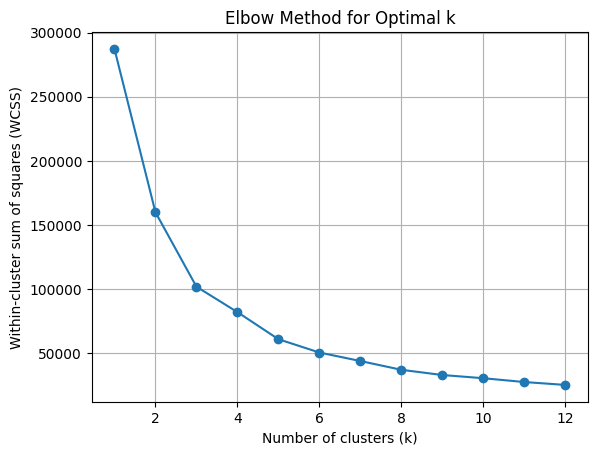

In [21]:
plt.plot(k_vals, wcss_vals, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.xticks
plt.grid(True)
plt.show()

In [117]:
# print the silhouette score
# print(silhouette_score(data_pca, pred_y))

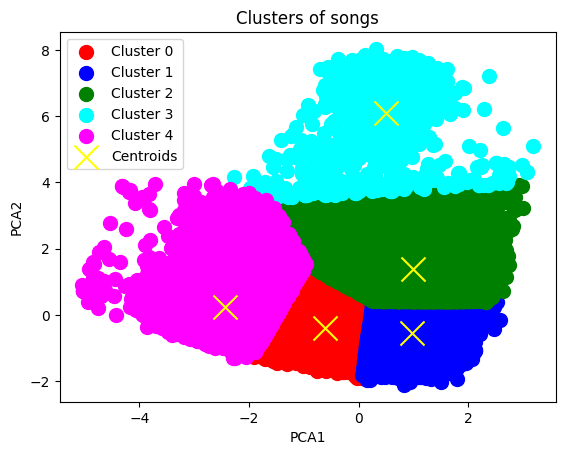

In [22]:
# plot the clusters
plt.scatter(data_pca[pred_y == 0, 0], data_pca[pred_y == 0, 1], s=100, c='red', label='Cluster 0')
plt.scatter(data_pca[pred_y == 1, 0], data_pca[pred_y == 1, 1], s=100, c='blue', label='Cluster 1')
plt.scatter(data_pca[pred_y == 2, 0], data_pca[pred_y == 2, 1], s=100, c='green', label='Cluster 2')
plt.scatter(data_pca[pred_y == 3, 0], data_pca[pred_y == 3, 1], s=100, c='cyan', label='Cluster 3')
plt.scatter(data_pca[pred_y == 4, 0], data_pca[pred_y == 4, 1], s=100, c='magenta', label='Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids', marker='x')
plt.title('Clusters of songs')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [119]:
# histogram
# playlist_0.hist(figsize=(12, 8), bins=20)
# plt.tight_layout()
# plt.show()

## Sort Dataset by Cluster & Distance-to-Cluster

In [23]:
# add a column to the dataset for the cluster number and distance from the centroid
dataset['cluster'] = pred_y
dataset['distance'] = kmeans.fit_transform(data_pca).min(axis=1)

# sort the dataset by cluster and distance
dataset = dataset.sort_values(by=['cluster', 'distance'])

dataset.head(10)

,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo,cluster,distance
11053,Kiss from a Rose,Seal,british,3YKptz29AsOlm7WAVnztBh,1.982515,0.123574,-0.395388,1.324892,-0.502682,1.051407,0.456840,0.321631,0,0.001717
54154,isle of the blest,tstewart;Machinedrum,idm,3jW0pK6SS8vH2wKLjlBLBm,0.233304,-0.866860,-0.056343,1.605800,-0.477964,0.906574,-0.492446,0.596024,0,0.009649
56650,Hrs & Hrs,Muni Long,indie-pop,3M5azWqeZbfoVkGXygatlb,2.128282,-0.221663,-0.442152,0.201257,0.631711,0.823811,-0.564284,0.394944,0,0.011405
84801,An American Prayer,Jim Morrison;The Doors,psych-rock,2VDkE9sdVpQAgEqH5fvTMV,0.573428,0.802729,-0.808476,0.482166,-0.236960,0.244476,0.082257,-0.387461,0,0.012702
97597,Um Degrau Na Escada,Chico Rey & Paraná,sertanejo,5Pn6spaFtc1kEk2HI86SaW,0.573428,-0.012257,-0.130387,-0.360560,-0.543291,0.906574,-0.107600,0.404142,0,0.016436
94794,Walking Through The Rain,SadBoyProlific;Iriasona,sad,03Nx63Qf5HnqGF3KkGIJ6l,0.913553,0.282044,-1.050094,0.482166,0.684679,1.054363,-0.595072,1.795797,0,0.018445
8735,Casa Con Diez Pinos,Manal,blues,2Ras7UcXvzenVmkyVMibdh,0.087536,-0.193365,-0.278476,-0.922377,-0.409988,1.116435,-0.348770,1.538803,0,0.018461
40466,Tu És Meu Socorro,Marcos Freire,gospel,7ehQuGJjYtcJ03dlA8uK3B,0.379072,-0.295238,-0.321344,-0.922377,-0.507979,-0.287566,-0.297458,-1.069194,0,0.018643
20127,Love Me More,Sam Smith,dance,4gVEvqKXRFe2WarhQxMzjP,-1.467318,1.295116,-0.761712,1.324892,-0.202531,-0.077705,-0.466790,-1.230331,0,0.018941
41286,Just Plain Bad,Angry Johnny and the Killbillies,goth,3TUIbBibx1RMF67PdrN2Bm,-0.301177,-0.855541,-0.851344,1.043983,-0.381739,-0.835570,-0.548890,-0.952517,0,0.019270


# Song Recommendations

In [24]:
# search for song's full data using the track_id
song_matches = dataset[dataset['track_id'] == track_id]

# get the first occurrence
full_given_song = song_matches.loc[song_matches.first_valid_index()]

# save the numerical data in a separate variable
given_song = full_given_song[4:].astype(float)

given_song

popularity      2.468407
danceability    0.966858
energy          0.294392
key            -0.079651
speechiness    -0.514158
acousticness   -0.541764
liveness       -0.622781
tempo           0.196454
cluster         1.000000
distance        1.192980
Name: 57317, dtype: float64

In [25]:
# consider ensemble clustering by running dbscan on each cluster to find subclusters

# given a song, find the most similar song in the same cluster
from sklearn.metrics.pairwise import euclidean_distances

## Initial Cluster Points & Filtering

In [26]:
# find the closest centroid

# get the index of the closest centroid
closest_centroid_idx = int(given_song['cluster'])

# get the coordinates of the closest centroid
closest_centroid = kmeans.cluster_centers_[closest_centroid_idx]

# Find data points belonging to the closest cluster
cluster_points = dataset.iloc[:, :][kmeans.labels_ == closest_centroid_idx]

# Remove the given song from the closest cluster if it exists
cluster_points = cluster_points[cluster_points['track_name'] != full_given_song['track_name']]

# Only consider songs of the same genre
# TODO: create clusters of genres that are similar and only from the that cluster
cluster_points = cluster_points[cluster_points['track_genre'] == full_given_song['track_genre']]

# print the amount of songs filtered
print(cluster_points.shape)

cluster_points.head(10)

(69, 14)


,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo,cluster,distance
57348,SKR,Zoé,indie,1gVKw1G0tDBCLvZqTpeSg5,-1.613085,-0.232982,0.173583,1.605800,-0.515041,0.454338,-0.637148,-0.965102,0,0.264724
57718,Amar Bhitor O Bahire,Somlata And The Aces;Somlata Acharyya Chowdhury,indie,2yY8uyFsf5smk2FbUDlj96,0.524839,0.117914,0.029392,-0.360560,-0.485909,0.525277,-0.648950,-0.565797,0,0.319251
57787,Kadhalar,Tenma;Sidanth Sundar;Kavitha Gopi,indie,4AtyyejGGiURUVbB1HQ7y4,0.476250,-0.663114,-0.391491,-0.360560,-0.505330,-0.145688,-0.763377,-0.644522,0,0.320370
57419,"Shiddat (Female Version) [From ""Shiddat""]",Yohani;Manan Bhardwaj,indie,7BadI3eRrbtM2vQSo8nPSa,0.670607,-0.561240,-0.504505,-0.922377,-0.200766,-0.062926,-0.697697,0.925104,0,0.439048
57797,L'ultima notte,ARIETE,indie,6naHoAHySemDryKIXayYiU,-1.564496,0.316001,0.204760,-0.922377,-0.378208,-0.178202,-0.466790,-0.930404,0,0.455740
57214,Jeete Hain Chal,Kavita Seth,indie,7kl1KAzW5O4gOAesaHxiq0,0.913553,0.038680,-0.134285,0.763074,-0.445300,0.956822,-0.477052,-0.996778,0,0.455757
57981,11 AM Blues,Aditya A,indie,7qRdYNa76Z6Zh6ZUQNRday,0.379072,0.961198,-0.181049,-0.079651,-0.447949,0.575525,-0.628425,-0.899060,0,0.466561
57251,Deep End,Fousheé,indie,6HlE9t71z9DjGi7KqSyEpA,1.739569,0.842346,-0.165461,-0.360560,1.258496,1.270136,-0.312851,0.089340,0,0.481199
57373,I Love You So,The Walters,indie,73WInbzcrppphpw0PK55gw,-1.564496,0.072637,0.052774,1.324892,-0.455894,0.752872,-0.523234,-1.530058,0,0.567112
57372,I Love You So,The Walters,indie,0u15XLJIKeIGYmT32AUSzp,-1.613085,0.072637,0.052774,1.324892,-0.455894,0.752872,-0.523234,-1.530058,0,0.577020


In [27]:
from sklearn.metrics import pairwise_distances_argmin_min

# get the pca-version of the given song
given_song_pca = pca.transform([given_song.iloc[:8]])
print(given_song_pca)
# calculate distances from the given song to all songs in the cluster
ten_songs_pca = []

# TODO: fix the data type differences
for i in range(10):
    ten_songs_pca += [pca.transform([cluster_points.iloc[i, 4:12].astype(float)])]
print(ten_songs_pca)
# indices, distances = pairwise_distances_argmin_min(given_song_pca, ten_songs_pca)

# # get indices of the 10 closest songs
# closest_songs_indices = distances.argsort()[:10]

# # plot the given song
# plt.scatter(given_song_pca[0][0], given_song_pca[0][1], s=300, c='black', label='Given Song')

# # plot the first 10 songs closest to the given song
# for idx in closest_songs_indices:
#     song_pca = data_pca[idx]
#     plt.scatter(song_pca[0], song_pca[1], s=100, c='blue', label='Closest Songs')

# plt.title('Songs closest to the given song')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.legend()
# plt.show()

[[ 0.71922531 -1.71138389]]
[array([[-0.64148193, -0.14498294]]), array([[-0.63314123, -0.72578685]]), array([[-0.70092762, -0.71406554]]), array([[-0.2863246 , -0.70663844]]), array([[-0.24343559, -0.13372034]]), array([[-1.02861337, -0.58242059]]), array([[-0.70631515, -0.86357577]]), array([[-0.49737091,  0.06082316]]), array([[-1.01239345, -0.01021635]]), array([[-1.01442387,  0.00179334]])]


/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklear

/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/joaquinmendoza/Downloads/cs/class/cs-450/spotify-cluster/venv/lib/python3.13/site-packages/sklear

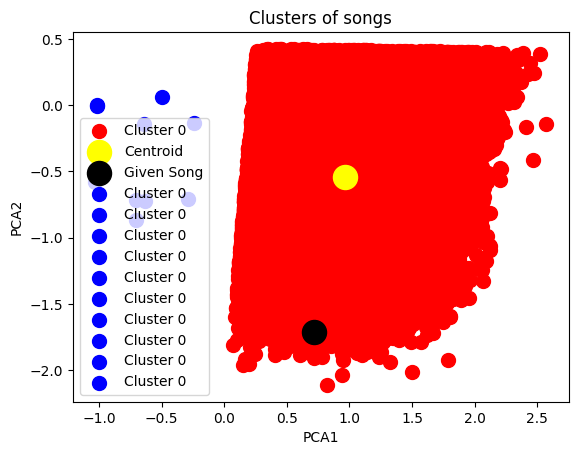

In [28]:
# Plot the cluster points
plt.scatter(data_pca[pred_y == closest_centroid_idx, 0], data_pca[pred_y == closest_centroid_idx, 1], s=100, c='red', label='Cluster 0')
plt.scatter(closest_centroid[0], closest_centroid[1], s=300, c='yellow', label='Centroid')

# get the pca-version of the given song
given_song_pca = pca.transform([given_song.iloc[:8]])

# plot the given song
plt.scatter(given_song_pca[0][0], given_song_pca[0][1], s=300, c='black', label='Given Song')

# plot the first 10 songs (iterate thru cluster_points)
for i in range(10):
    song_pca = pca.transform([cluster_points.iloc[i, 4:12]]) # view this line
    plt.scatter(song_pca[0][0], song_pca[0][1], s=100, c='blue', label='Cluster 0')

plt.title('Clusters of songs')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [124]:
# Get the genre words from the given song
song_genre_words = full_given_song['track_genre'].split()
song_genre_words = ' '.join(song_genre_words)

# remove '-' from genre words
if '-' in song_genre_words:
    # split the genre into words
    song_genre_words = song_genre_words.split('-')

# join all words that exist in both lists
genre_words = [word for word in song_genre_words if word in artist_genres_words]
# genre_words = ' '.join(genre_words)

# join all genres similar to genre words
for genre in genres_searchable:
    if any(word in genre for word in genre_words):

        # turn genre back into hyphenated string
        if len(genre) > 1:
            genre = '-'.join(genre)
        else:
            genre = genre[0]

        # keep only unique genres
        if genre not in genre_words:
            genre_words.append(genre)

# print(genre_words)

# Compare genre words between the given song and the closest cluster points
cluster_points = cluster_points[cluster_points['track_genre'].isin(genre_words)]

# print(song_genre_words)
# cluster_points = cluster_points[cluster_points['track_genre'] in artist_genres_words]

# Only keep one song per artist
cluster_points = cluster_points.drop_duplicates(subset='artists')

# Get songs with a similar given attribute
attributes = ['speechiness', 'popularity', 'danceability', 'energy', 'acousticness', 'liveness', 'tempo']
sensitivity = 1

for attribute in attributes:
    cluster_points = cluster_points[
        (cluster_points[attribute] >= full_given_song[attribute] - sensitivity) & (
                cluster_points[attribute] <= full_given_song[attribute] + sensitivity)]

print("\nFOUND", len(cluster_points), "SIMILAR SONGS\n")

print(full_given_song[:3])
# print(data.iloc[song_idx, :])


FOUND 0 SIMILAR SONGS

Index(['track_name', 'artists', 'track_genre'], dtype='object')


In [47]:
# find the 2nd closest song
distances = euclidean_distances(cluster_points.iloc[:, 3:], [given_song])

closest_song_indices = distances.flatten().argsort()

second_closest_song_idx = closest_song_indices[1:10]
print("Given song: \"" + full_given_song[:3]['track_name'] + "\" by", full_given_song[:3]['artists'], "| Genre:", full_given_song[:3]['track_genre'])
print("\nSong Recommendations:")
print("=====================================")

pd.set_option('display.width', 1000)
recommendations = cluster_points.iloc[second_closest_song_idx, :3]
print(recommendations)

ValueError: Found array with 0 sample(s) (shape=(0, 8)) while a minimum of 1 is required by check_pairwise_arrays.

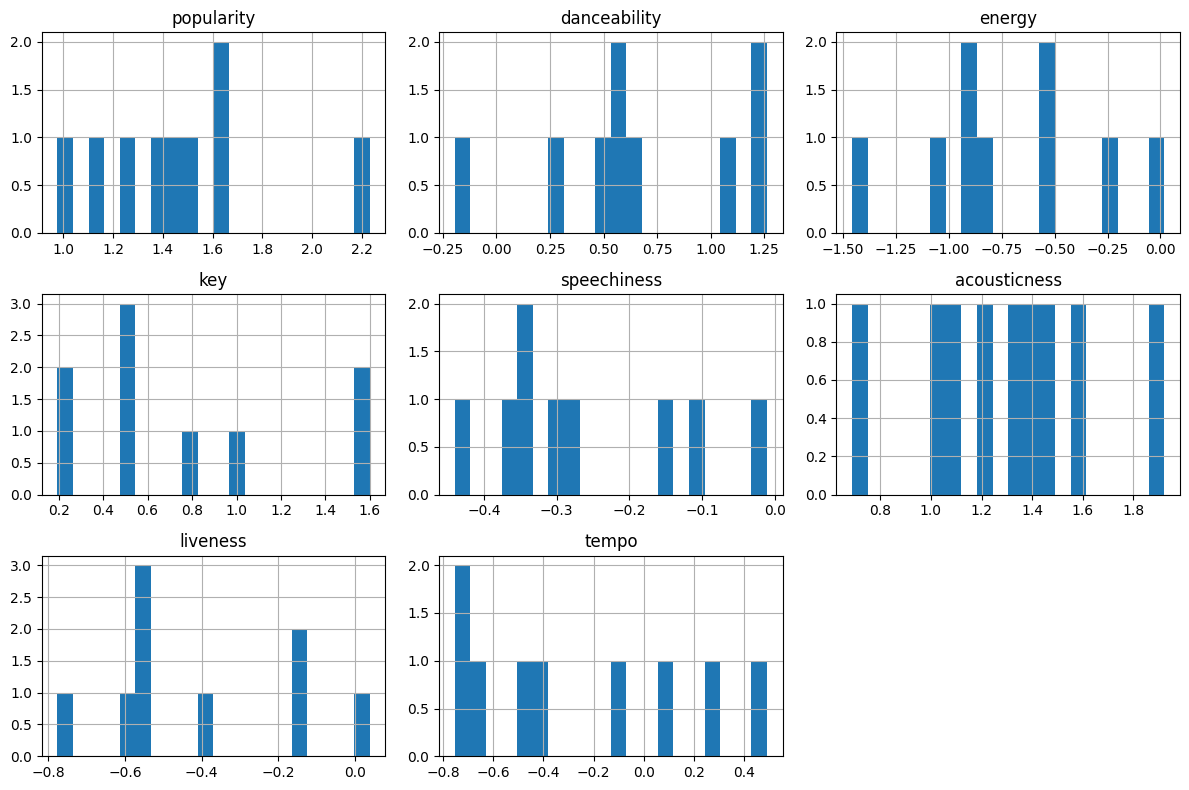

In [ ]:
# plot histogram of the recommendations pd dataframe
recs = cluster_points.iloc[second_closest_song_idx]
recs.hist(figsize=(12, 8), bins=20)
# label x-axis with song names
plt.xticks(rotation=45)
plt.xlabel('track_name')
plt.tight_layout()
plt.show()

In [ ]:
# Filter only songs from the same genre
cluster_points = cluster_points[dataset['track_genre'] == dataset.iloc[song_idx, 2]]

In [ ]:
# Calculate distances
distances = euclidean_distances([given_song], cluster_points)

# Get indices of K closest data points
k_closest_indices = distances.argsort(axis=1)[0][:4]

# # Get K closest data points
k_closest_points = cluster_points.iloc[k_closest_indices]

# query the dataset for the closest songs based on the indices
closest_songs = dataset.iloc[k_closest_indices]
# print(closest_songs)